In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from MPCProblem import MPCProblem
from util import *
import cvxpy as cp
import warnings
import itertools
import time
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
import graphviz
import pydotplus
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import brier_score_loss
from scipy import stats
import matplotlib.dates as md
warnings.filterwarnings('ignore')

In [5]:
peak_flows = [310.995288, 95.952598, 140.088000, 67.040000, 77.467000, 83.829000] # kcfs
peak_flows1 = [310.995288, 95.952598, 140.088000, 67.040000, 77.467000, 83.829000] # kcfs
peak_flows2 = [178.639267, 39.204113, 48.732, 28.314, 26.488, 40.544]
flood_pools = [750, 170, 340, 350, 170, 450] # TAF
sites = ['ORDC1', 'NBBC1', 'NDPC1', 'EXQC1', 'FRAC1', 'NMSC1']
site_n = 0
site = sites[site_n]

# Feb 2017 event ORDC1 heatmap
# Rmax, RR, LT
df_input = pd.read_csv('output/CART_input_%s_LT_full.csv' %site, index_col = 0)
df_input.columns = ['Rmax', 'RR', 'LT',
                    'max_above_TOCS_baseline',
                    'max_above_TOCS_perfect',
                    'max_above_TOCS_hefs']

b_cut = 1 * flood_pools[site_n]
p_cut = 1

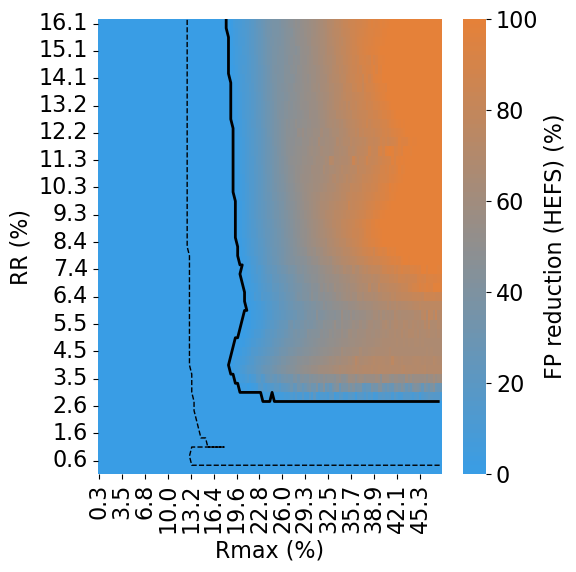

In [7]:
# plot Rmax vs RR keeping LT at 14 days

Z = 14

z = 'LT'

df_temp = df_input[df_input[z] == Z]

x = 'Rmax'
y = 'RR'

x_unit = "%"
y_unit = "%"


columns = df_input[x].unique()

index = df_input[y].unique()

df_plot = pd.DataFrame()
df_plot_perfect = pd.DataFrame()
for n, X in enumerate(columns):
    df_plot[X] = df_temp[df_temp[x] == X]['max_above_TOCS_hefs'].reset_index(drop = True)
    df_plot_perfect[X] = df_temp[df_temp[x] == X]['max_above_TOCS_perfect'].reset_index(drop = True)

df_plot.index = index
df_plot_perfect.index = index

df_plot_copy = df_plot.copy()
df_plot_perfect_copy = df_plot_perfect.copy()

flood_pool = b_cut

# 0: good job; 1: hefs policy exceeded; 2: perfect exceeded
df_plot = df_plot.where(df_plot_copy>flood_pool, 0)
df_plot = df_plot.where(df_plot_copy<flood_pool, 1) # where condition is false

# try plotting the the exact value
df_plot_exact_normalized = 100*(1 - df_plot_copy/flood_pool) # FP reduction
df_shit = df_plot_exact_normalized.copy()
df_plot_exact_normalized = df_plot_exact_normalized.where(df_plot_exact_normalized>0, 0) # 0% FPT all set to 0

df_heatmap =  df_plot[df_plot.index.isin(index)][np.sort(columns)] # binary classification
df_heatmap_norm = df_plot_exact_normalized[df_plot_exact_normalized.index.isin(index)][np.sort(columns)] 

# add this, where perfect case fail
df_plot_exact_normalized_perfect =  100*(1 - df_plot_perfect_copy/flood_pool) # % of flood pool ^_^
df_plot_exact_normalized_perfect = df_plot_exact_normalized_perfect.where(df_plot_exact_normalized_perfect>0, 200) # perfect-worse: all set to 2

# add where perfect is perferct
df_heatmap_perfect = df_plot_exact_normalized_perfect[df_plot_exact_normalized_perfect.index.isin(index)][np.sort(columns)] # add perfect hatches

peak_inflow = peak_flows1[site_n]
    
plt.rcParams.update({'font.size': 16})

heatmaps = [df_heatmap, df_heatmap_perfect, df_heatmap_norm]

scale_to_peak = True # for Rmax and RR

for heatmap in heatmaps:
    if scale_to_peak:
        heatmap.columns = (100*heatmap.columns/peak_inflow).round(1)
    
        if y != "LT":
            heatmap.index = (100*heatmap.index/peak_inflow).round(1)

fig, ax = plt.subplots(figsize = (6,6))
if (df_heatmap-1).sum().sum() == 0: # remain only worse class 1
    cmap = ["#399DE5"]
else: # two classes
    cmap = ["#E58139", "#399DE5",  "#399DE5"]

# sns.heatmap(df_heatmap, cmap=cmap, cbar = False)

# customized color map
# colors = ["#E58139", "#399DE5"]
colors = ["#399DE5","#E58139"]
cm = LinearSegmentedColormap.from_list("Custom", colors, N=100)

if y =='LT':
    df_heatmap_norm = df_heatmap_norm.sort_index(ascending = False)
    df_heatmap_perfect = df_heatmap_perfect.sort_index(ascending = False)

    
hm = sns.heatmap(df_heatmap_norm, cmap = cm, cbar = True, vmin = 0, vmax = 100, cbar_kws={'label': 'FP reduction (HEFS) (%)'})
threshold = 0
contour = plt.contour(df_heatmap_norm, levels=[threshold], colors='black', linewidths=2)

df_heatmap_norm[df_heatmap_perfect==200] = -1

contour_perfect = plt.contour(df_heatmap_norm, levels=[-1], colors='black', linewidths=1)

ax.set_xlabel(x + " (%s)" %x_unit)
ax.set_ylabel(y + " (%s)" %y_unit)
plt.tight_layout()

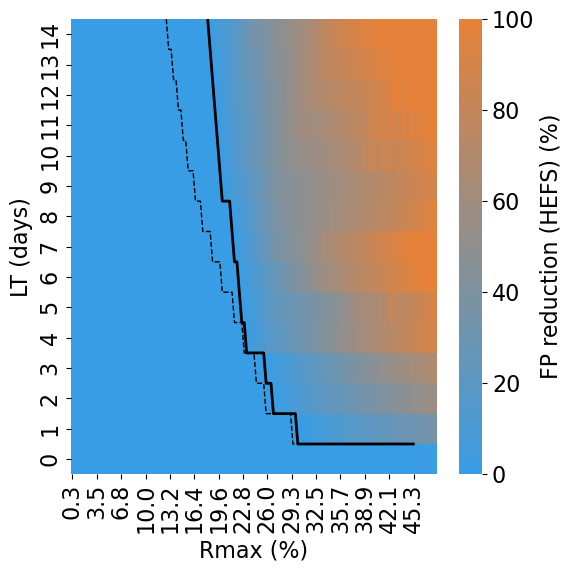

In [5]:
# plot Rmax vs LT keeping RR at 50

Z = 50

z = 'RR'

df_temp = df_input[df_input[z] == Z]

x = 'Rmax'
y = 'LT'

x_unit = "%"
y_unit = "days"


columns = df_input[x].unique()

index = df_input[y].unique()

df_plot = pd.DataFrame()
df_plot_perfect = pd.DataFrame()
for n, X in enumerate(columns):
    df_plot[X] = df_temp[df_temp[x] == X]['max_above_TOCS_hefs'].reset_index(drop = True)
    df_plot_perfect[X] = df_temp[df_temp[x] == X]['max_above_TOCS_perfect'].reset_index(drop = True)

df_plot.index = index
df_plot_perfect.index = index

df_plot_copy = df_plot.copy()
df_plot_perfect_copy = df_plot_perfect.copy()

flood_pool = b_cut

# 0: good job; 1: hefs policy exceeded; 2: perfect exceeded
df_plot = df_plot.where(df_plot_copy>flood_pool, 0)
df_plot = df_plot.where(df_plot_copy<flood_pool, 1) # where condition is false

# try plotting the the exact value
df_plot_exact_normalized = 100*(1 - df_plot_copy/flood_pool) # FP reduction
df_shit = df_plot_exact_normalized.copy()
df_plot_exact_normalized = df_plot_exact_normalized.where(df_plot_exact_normalized>0, 0) # 0% FPT all set to 0

df_heatmap =  df_plot[df_plot.index.isin(index)][np.sort(columns)] # binary classification
df_heatmap_norm = df_plot_exact_normalized[df_plot_exact_normalized.index.isin(index)][np.sort(columns)] 

# add this, where perfect case fail
df_plot_exact_normalized_perfect =  100*(1 - df_plot_perfect_copy/flood_pool) # % of flood pool ^_^
df_plot_exact_normalized_perfect = df_plot_exact_normalized_perfect.where(df_plot_exact_normalized_perfect>0, 200) # perfect-worse: all set to 2

# add where perfect is perferct
df_heatmap_perfect = df_plot_exact_normalized_perfect[df_plot_exact_normalized_perfect.index.isin(index)][np.sort(columns)] # add perfect hatches

peak_inflow = peak_flows1[site_n]
    
plt.rcParams.update({'font.size': 16})

heatmaps = [df_heatmap, df_heatmap_perfect, df_heatmap_norm]

scale_to_peak = True # for Rmax and RR

for heatmap in heatmaps:
    if scale_to_peak:
        heatmap.columns = (100*heatmap.columns/peak_inflow).round(1)
    
        if y != "LT":
            heatmap.index = (100*heatmap.index/peak_inflow).round(1)

fig, ax = plt.subplots(figsize = (6,6))
if (df_heatmap-1).sum().sum() == 0: # remain only worse class 1
    cmap = ["#399DE5"]
else: # two classes
    cmap = ["#E58139", "#399DE5",  "#399DE5"]

# sns.heatmap(df_heatmap, cmap=cmap, cbar = False)

# customized color map
# colors = ["#E58139", "#399DE5"]
colors = ["#399DE5","#E58139"]
cm = LinearSegmentedColormap.from_list("Custom", colors, N=100)

if y =='LT':
    df_heatmap_norm = df_heatmap_norm.sort_index(ascending = False)
    df_heatmap_perfect = df_heatmap_perfect.sort_index(ascending = False)

    
hm = sns.heatmap(df_heatmap_norm, cmap = cm, cbar = True, vmin = 0, vmax = 100, cbar_kws={'label': 'FP reduction (HEFS) (%)'})
threshold = 0
contour = plt.contour(df_heatmap_norm, levels=[threshold], colors='black', linewidths=2)

df_heatmap_norm[df_heatmap_perfect==200] = -1

contour_perfect = plt.contour(df_heatmap_norm, levels=[-1], colors='black', linewidths=1)

ax.set_xlabel(x + " (%s)" %x_unit)
ax.set_ylabel(y + " (%s)" %y_unit)
plt.tight_layout()

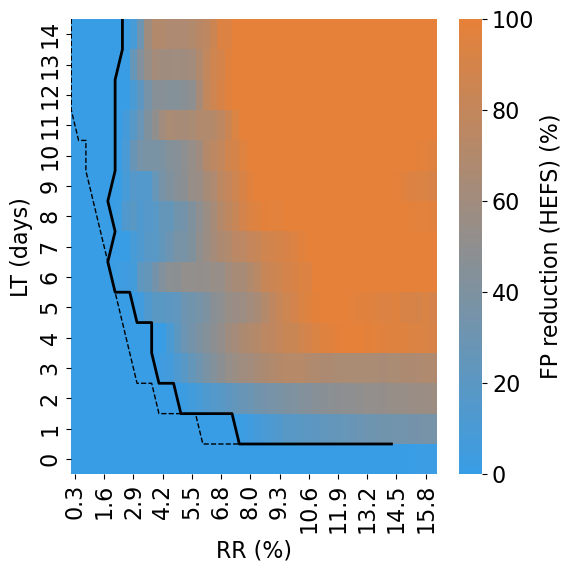

In [6]:
# plot RR vs LT keeping Rmax at 150

Z = 150

z = 'Rmax'

df_temp = df_input[df_input[z] == Z]

x = 'RR'
y = 'LT'

x_unit = "%"
y_unit = "days"


columns = df_input[x].unique()

index = df_input[y].unique()

df_plot = pd.DataFrame()
df_plot_perfect = pd.DataFrame()
for n, X in enumerate(columns):
    df_plot[X] = df_temp[df_temp[x] == X]['max_above_TOCS_hefs'].reset_index(drop = True)
    df_plot_perfect[X] = df_temp[df_temp[x] == X]['max_above_TOCS_perfect'].reset_index(drop = True)

df_plot.index = index
df_plot_perfect.index = index

df_plot_copy = df_plot.copy()
df_plot_perfect_copy = df_plot_perfect.copy()

flood_pool = b_cut

# 0: good job; 1: hefs policy exceeded; 2: perfect exceeded
df_plot = df_plot.where(df_plot_copy>flood_pool, 0)
df_plot = df_plot.where(df_plot_copy<flood_pool, 1) # where condition is false

# try plotting the the exact value
df_plot_exact_normalized = 100*(1 - df_plot_copy/flood_pool) # FP reduction
df_shit = df_plot_exact_normalized.copy()
df_plot_exact_normalized = df_plot_exact_normalized.where(df_plot_exact_normalized>0, 0) # 0% FPT all set to 0

df_heatmap =  df_plot[df_plot.index.isin(index)][np.sort(columns)] # binary classification
df_heatmap_norm = df_plot_exact_normalized[df_plot_exact_normalized.index.isin(index)][np.sort(columns)] 

# add this, where perfect case fail
df_plot_exact_normalized_perfect =  100*(1 - df_plot_perfect_copy/flood_pool) # % of flood pool ^_^
df_plot_exact_normalized_perfect = df_plot_exact_normalized_perfect.where(df_plot_exact_normalized_perfect>0, 200) # perfect-worse: all set to 2

# add where perfect is perferct
df_heatmap_perfect = df_plot_exact_normalized_perfect[df_plot_exact_normalized_perfect.index.isin(index)][np.sort(columns)] # add perfect hatches

peak_inflow = peak_flows1[site_n]
    
plt.rcParams.update({'font.size': 16})

heatmaps = [df_heatmap, df_heatmap_perfect, df_heatmap_norm]

scale_to_peak = True # for Rmax and RR

for heatmap in heatmaps:
    if scale_to_peak:
        heatmap.columns = (100*heatmap.columns/peak_inflow).round(1)
    
        if y != "LT":
            heatmap.index = (100*heatmap.index/peak_inflow).round(1)

fig, ax = plt.subplots(figsize = (6,6))
if (df_heatmap-1).sum().sum() == 0: # remain only worse class 1
    cmap = ["#399DE5"]
else: # two classes
    cmap = ["#E58139", "#399DE5",  "#399DE5"]

# sns.heatmap(df_heatmap, cmap=cmap, cbar = False)

# customized color map
# colors = ["#E58139", "#399DE5"]
colors = ["#399DE5","#E58139"]
cm = LinearSegmentedColormap.from_list("Custom", colors, N=100)

if y =='LT':
    df_heatmap_norm = df_heatmap_norm.sort_index(ascending = False)
    df_heatmap_perfect = df_heatmap_perfect.sort_index(ascending = False)

    
hm = sns.heatmap(df_heatmap_norm, cmap = cm, cbar = True, vmin = 0, vmax = 100, cbar_kws={'label': 'FP reduction (HEFS) (%)'})
threshold = 0
contour = plt.contour(df_heatmap_norm, levels=[threshold], colors='black', linewidths=2)

df_heatmap_norm[df_heatmap_perfect==200] = -1

contour_perfect = plt.contour(df_heatmap_norm, levels=[-1], colors='black', linewidths=1)

ax.set_xlabel(x + " (%s)" %x_unit)
ax.set_ylabel(y + " (%s)" %y_unit)
plt.tight_layout()